[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/033_receta_entrenamiento/receta_entrenamiento.ipynb)

#LABORATORIO 1 - Entrenamiento con el framework Sonnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Instalar Sonnet y TensorFlow

In [ ]:
pip install dm-sonnet tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.4/268.4 kB 11.7 MB/s eta 0:00:00


# 2. Cargar el dataset y aplicar transformaciones y luego procesarlo con Sonnet
Cambiamos para usar TensorFlow y tensorflow_datasets.

Found 10010 files belonging to 5 classes.
Using 8008 files for training.
Found 10010 files belonging to 5 classes.
Using 2002 files for validation.
PRIMER BATCH TRAIN DATASET: Tamaño de imágenes: (16, 28, 37, 3)
PRIMER BATCH TRAIN DATASET: Tamaño de etiquetas: (16,)
Clases: ['laurel', 'limon', 'membrillo', 'olivo', 'papaya']


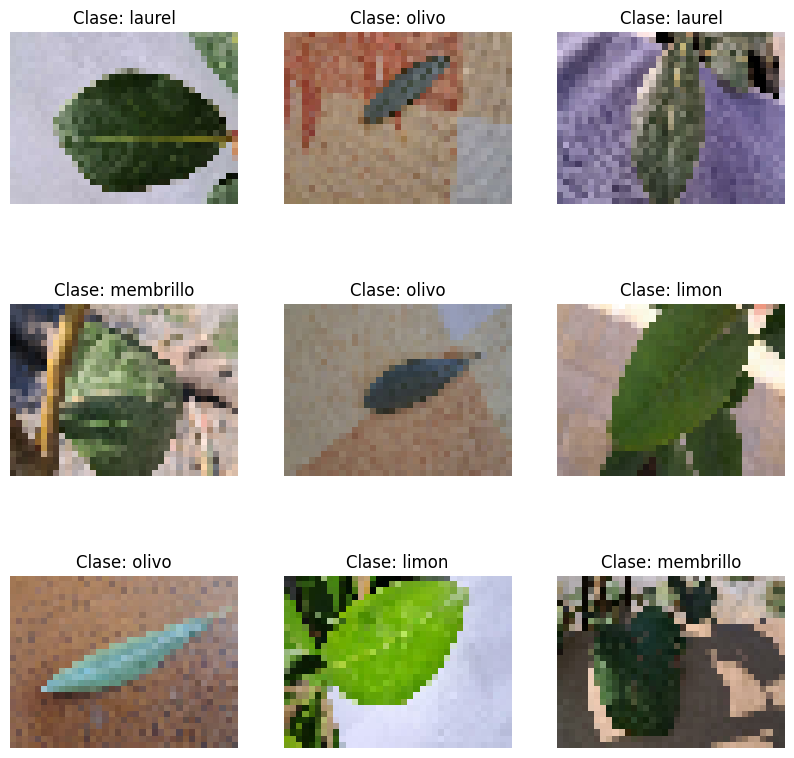

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Ruta a tu dataset en Google Drive
data_dir = '/content/drive/MyDrive/SIS 421/Lab2/dataset_plantas'

# Cargar el dataset desde el directorio
batch_size = 16
img_height = 28
img_width = 37

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Usamos 20% de los datos para validación
    subset="training",
    seed=123,  # Para asegurar que la separación de datos sea reproducible
    image_size=(img_height, img_width),  # Redimensionamos las imágenes
    batch_size=batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Verificar los primeros batches
for images, labels in train_dataset.take(1):
    print(f"PRIMER BATCH TRAIN DATASET: Tamaño de imágenes: {images.shape}")
    print(f"PRIMER BATCH TRAIN DATASET: Tamaño de etiquetas: {labels.shape}")

# Obtener las clases (nombres de las subcarpetas)
class_names = train_dataset.class_names
print(f"Clases: {class_names}")

# Visualizar las imágenes
def imshow(img):
    plt.imshow(img)
    plt.axis('off')

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Clase: {class_names[labels[i]]}")
    plt.show()


# 3. Definir el modelo con Sonnet
Sonnet simplifica la construcción de redes neuronales. Definimos el MLP usando snt.Sequential y capas densas.

In [ ]:
# Modelo MLP con Sonnet
class MLP(snt.Module):
    def __init__(self, input_size=28*37*3, hidden_size=50, output_size=5):
        super().__init__()
        self.model = snt.Sequential([
            snt.Flatten(),
            snt.Linear(hidden_size),
            tf.nn.relu,
            snt.Linear(output_size)
        ])

    def __call__(self, x):
        return self.model(x)

# Crear el modelo
model = MLP()


# 4. Entrenamiento del modelo
En lugar de utilizar las funciones de optimización de PyTorch, ahora usaremos tf.keras para definir el optimizador y la pérdida. Luego realizamos el entrenamiento con Sonnet y TensorFlow.

In [ ]:
# Configurar el optimizador y la función de pérdida
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Definir un paso de entrenamiento
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images)
        loss = loss_fn(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits  # Regresar las predicciones también

# Entrenamiento por 200 épocas con un solo batch
epochs = 200
for epoch in range(epochs):
    for images, labels in train_dataset.take(1):  # Extraer un solo batch
        loss, logits = train_step(images, labels)

    # Obtener predicciones y clases verdaderas
    y_pred = tf.argmax(logits, axis=1)  # Predicciones
    y_true = labels  # Clases verdaderas

    # Imprimir resultados cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}    Loss: {loss.numpy():.5f}      y_true: {y_true.numpy()}      y_pred: {y_pred.numpy()}")


Epoch 10/200    Loss: 1.56785      y_true: [3 2 3 0 1 4 3 4 3 3 3 3 4 3 1 0]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 20/200    Loss: 1.59306      y_true: [3 3 1 3 0 1 2 4 2 1 0 4 4 4 3 2]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 30/200    Loss: 1.57752      y_true: [1 4 3 3 3 4 3 0 1 4 1 3 1 3 1 3]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 40/200    Loss: 1.55025      y_true: [3 4 3 4 1 2 4 3 3 0 2 4 1 3 2 4]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 50/200    Loss: 1.60055      y_true: [0 3 0 3 3 0 4 0 3 2 2 2 0 4 4 2]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 60/200    Loss: 1.69702      y_true: [0 0 1 3 0 0 1 0 0 3 1 3 4 4 1 0]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 70/200    Loss: 1.60402      y_true: [4 1 2 4 2 3 4 3 1 2 0 2 1 0 3 4]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 80/200    Loss: 1.59368      y_true: [4 4 1 1 3 4 2 0 2 4 2 2 3 1 4 4]      y_pred: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Epoch 90